# Forecasting time series with ARIMA

In [73]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0)

# TSA from Statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt

from datetime import datetime

In [3]:
#load daily data from Yahoo Finance
# download dataframe
data = pdr.get_data_yahoo("SPY", start="2017-01-01", end="2019-01-01")


[*********************100%***********************]  1 of 1 downloaded


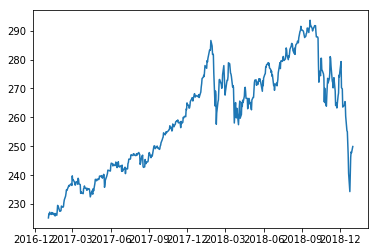

In [4]:
#Visualize to familiarize ourselves with it
plt.plot(data['Close'])

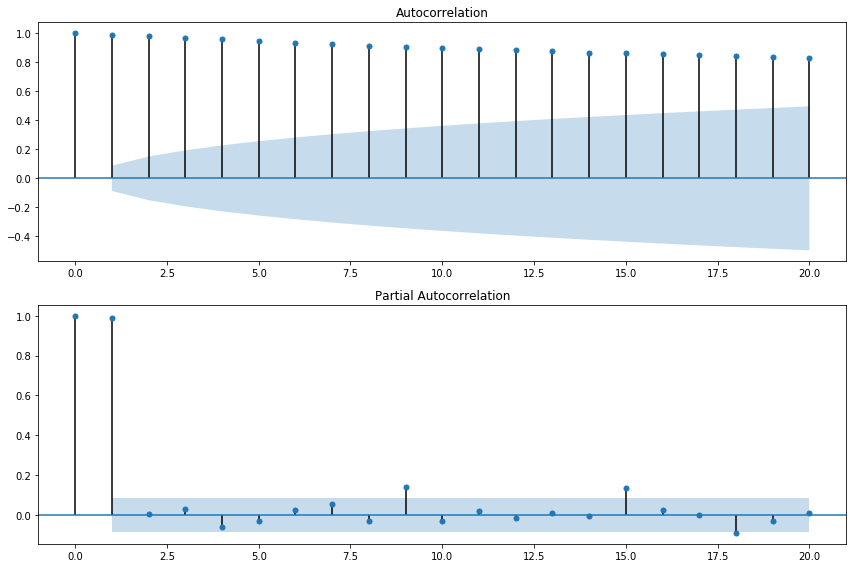

In [5]:
#Explore the data for autocorrelation and partial autocorrelation
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data['Close'], lags=20, ax=ax1)
ax1.xaxis.set_ticks_position('bottom')
fig.tight_layout();

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data['Close'], lags=20, ax=ax2)
ax2.xaxis.set_ticks_position('bottom')
fig.tight_layout();

In [6]:
# Plot the four essential plots all at once

def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Original source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    #sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

(<matplotlib.axes._subplots.AxesSubplot at 0x235266e9eb8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x235262205c0>)

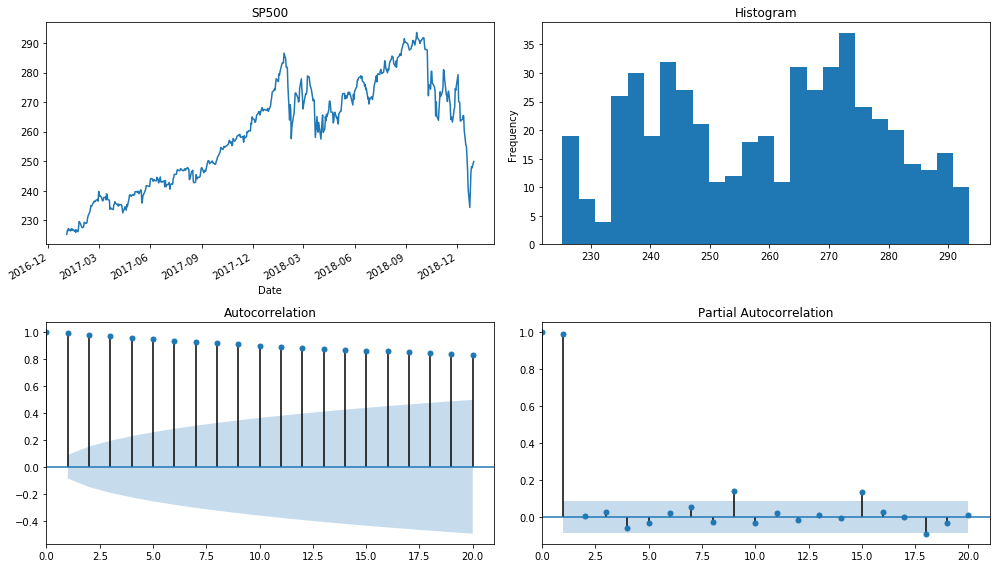

In [7]:
tsplot(data['Close'], title='SP500', lags=20)

We can see from the chart that this time series is non-stationary and is highly correlated over 20 lags.  The partial autocorrelation shows us that almost all of the autocorrelation can be reduced with a lag of 1, which is achievable by first differencing.

(<matplotlib.axes._subplots.AxesSubplot at 0x23526307048>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2352694d3c8>)

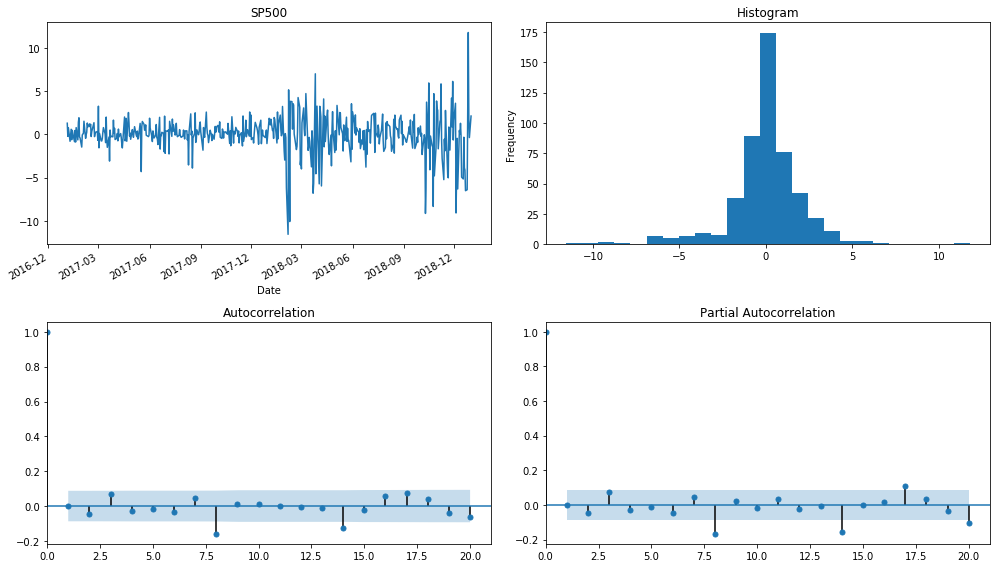

In [8]:
#Make the data stationary using first differences.
dtrans = data['Close'].diff().dropna()

#Remove the mean, even though it appears to be nearly zero
dtrans -= dtrans.mean()

#Lets re-evaluate
tsplot(dtrans, title='SP500', lags=20)

This looks much better and is now suitable for use in ARIMA.

In [9]:
#Split the dataset into a train and test set to evaluate the performance of the forecast.
tenpercent = int(dtrans.size * 0.10 )
train, test = dtrans[:-tenpercent], dtrans[-tenpercent:]

In [66]:
# Fit the model
arima200 = sm.tsa.SARIMAX(train, order=(2,0,0))
model_results = arima200.fit()
model_results.summary()

C:\Program Files\Anaconda2\envs\python3.3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  Close   No. Observations:                  451
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -912.711
Date:                Tue, 19 Feb 2019   AIC                           1831.422
Time:                        11:00:36   BIC                           1843.757
Sample:                             0   HQIC                          1836.283
                                - 451                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0310      0.026     -1.207      0.227      -0.081       0.019
ar.L2         -0.1061      0.031     -3.428      0.001      -0.167      -0.045
sigma2         3.3520      0.112     29.979      0.000       3.133       3.571
===================================================================================
Ljung-Box (Q):                       57.16   Jarque-Bera (JB):              1361.46
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               4.64   Skew:                            -1.52
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

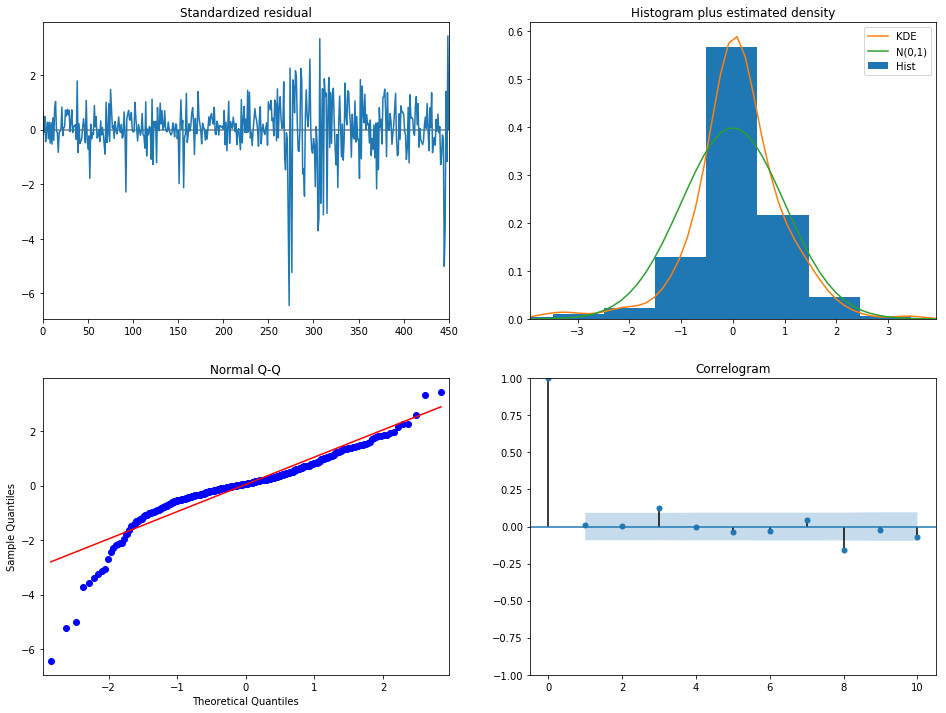

In [13]:
#Conduct visual inspection of the results
model_results.plot_diagnostics(figsize=(16, 12));

In [84]:
#data.index is a DatetimeIndex with dtype='datetime64[ns]'
#train.index is a DatetimeIndex with dtype='datetime64[ns]'
#train.index[0] is a Timestamp
#test.index is a DatetimeIndex with dtype='datetime64[ns]'
#est.index[0] is a Timestamp



Timestamp('2018-10-18 00:00:00')

In [95]:
#train.index.dtype
#train['2017-01-04']
pred_begin = train.index[model_results.loglikelihood_burn]
pred_end = test.index[-1]

#datetime.strptime(pred_begin, '%Y-%m-%d')
#train[pred_begin.strftime('%Y-%m-%d')]

#Lets produce a string
#pred_begin.strftime('%Y-%m-%d')

#lets see if it can be used to index into our data
#train[pred_begin.strftime('%Y-%m-%d')]  #yes
#train[pred_begin.strftime('%Y-%m-%d 00:00:00')] #also yes



AttributeError: 'SARIMAXResults' object has no attribute '_get_index_label_loc'

C:\Program Files\Anaconda2\envs\python3.3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


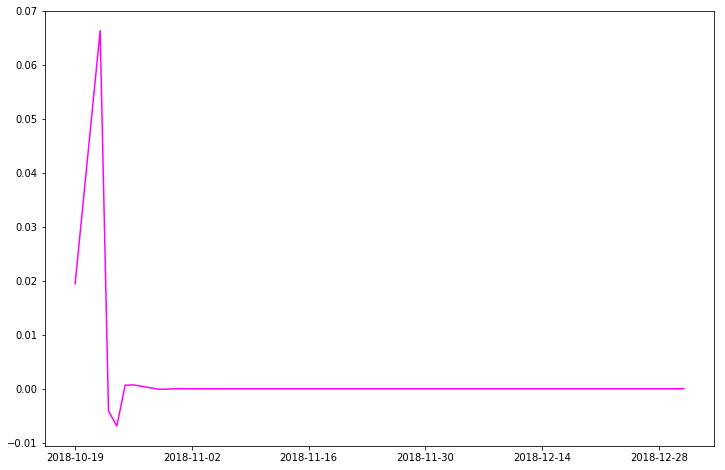

In [228]:
#train.index[model_results.loglikelihood_burn]
#pred_begin.strftime('%Y-%m-%d')
#test.index[-1]
#pred_end.strftime('%Y-%m-%d')
#model_results.loglikelihood_burn
#train.index[0]
#model_results.get_prediction(start=train.size).predicted_mean
#pred_mean
#pred_ci
#dtrans.index
#pred.predicted_mean

# yes DatetimeIndex

pred_begin = train.index[0]
pred_end = train.index[-1]
#test.index[0]
#pred_end
#pred = model_results.get_prediction(start=pred_begin.strftime('%Y-%m-%d'), end=pred_end.strftime('%Y-%m-%d'))
#pred_begin


#model_results.predict(start=pred_begin, end=pred_end, typ='levels')
#When we pass a Timestamp into predict it gives the error "TypeError: int() argument must be a string, a bytes-like object or a number, not 'Timestamp'"
#So lets give a string


#model_results.predict( start=pred_begin.strftime('%Y-%m-%d 00:00:00'), end=pred_end.strftime('%Y-%m-%d 00:00:00'), typ='levels')
#KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'
#Oh, does this mean it cannot find it in train???
#train.index[50]
#no because if I use train it works there.


#When I use integers I get a result from 2017-01-5 - 2017-02-16

#model_results.predict(0, 450, typ='levels')

#pred = model_results.get_prediction(0, 455)

#Predict will allow you to test out-of-sample data
#model_results.predict(0, 500, typ='levels')
pred = model_results.get_prediction(0, 500)

#If the end time is beyond the end of the training its index is an int.

#So the problem is, it cannot predict the datetimes that will appear in the future, because it
#doesn't know the frequency of the datetimes, so we need to generate those datetimes for it
#or maybe if we specify a custom frequency then it can generate the dates itself.

#for now, since we actually know the future dates since they are the index to the out-of-sample data
#we will reference those.

#pred.predicted_mean
#outofsampleforecast = pd.DataFrame(data=pred.predicted_mean[1:,1:],    # values
#            index=pred.predicted_mean[1:,0],    # 1st column as index
#            columns=pred.predicted_mean[0,1:])

#pred.predicted_mean


pdf= [(dtrans.index[i].strftime('%Y-%m-%d') ,x) for i,x in enumerate(pred.predicted_mean)]


predicted = pd.DataFrame({'Mean':pred.predicted_mean})
#predicted['Date'] = dtrans.index

#index = train.index .concat(test.index)
#predicted = pd.DataFrame(data=pdf[1,:], index=pdf[0,:], columns=['PredictedMean'])
predicted.set_index(dtrans.index, inplace=True)
#predicted

#test
plt.plot(predicted[predicted.index>'2018-10-18'], color='Magenta')
#predicted[predicted.index>'2018-10-15']








C:\Program Files\Anaconda2\envs\python3.3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


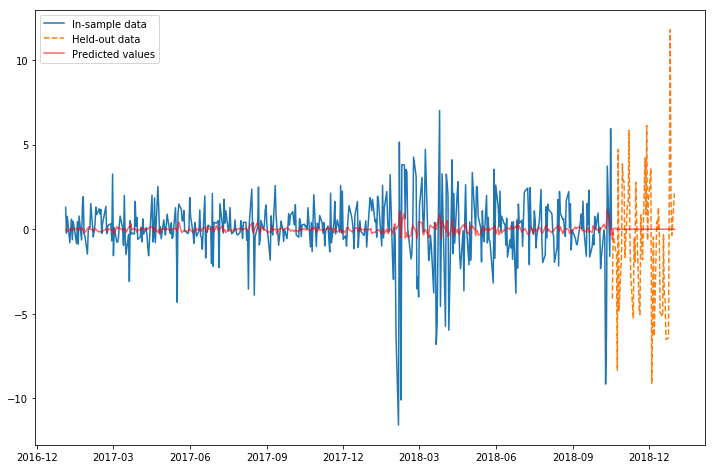

In [230]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
ax1.plot(train, label='In-sample data', linestyle='-')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(test, label='Held-out data', linestyle='--')

# yes DatetimeIndex
pred_begin = train.index[model_results.loglikelihood_burn]
pred_end = test.index[-1]

#Lets get a prediction on in-sample data
#pred = model_results.predict(0, 450, typ='levels')
#pred = model_results.get_prediction(0, 450)

#We will get our prediction for the whole train and test time period.
#But because this module doesn't project dates into the future it returns periods as an int.
#So we will reassociate with dates
pred = model_results.get_prediction(0, 500)
predicted = pd.DataFrame({'Mean':pred.predicted_mean})
predicted.set_index(dtrans.index, inplace=True)


#get_prediction doesn't work with datatimes, or datestrings
#pred = model_results.get_prediction(start=pred_begin.strftime('%Y-%m-%d'), end=pred_end.strftime('%Y-%m-%d'))
#pred = model_results.get_prediction(start=model_results.loglikelihood_burn, end=dtrans.size)

#There is not method plot_predict on the model_results object (leading me to believe this is a change in the module)
#model_results.plot_predict(0, 450, dynamic=True, ax=ax1,plot_insample=False)

#But now how to we test on out-of-sample data?  Forecasting?

#forecast = model_results.forecast(steps=50)


#pred_mean = pred.predicted_mean

ax1.plot(predicted, 'r', alpha=.6, label='Predicted values')

pred_ci = pred.conf_int(alpha=0.05)

#ax1.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax1.legend(loc='best');

C:\Program Files\Anaconda2\envs\python3.3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


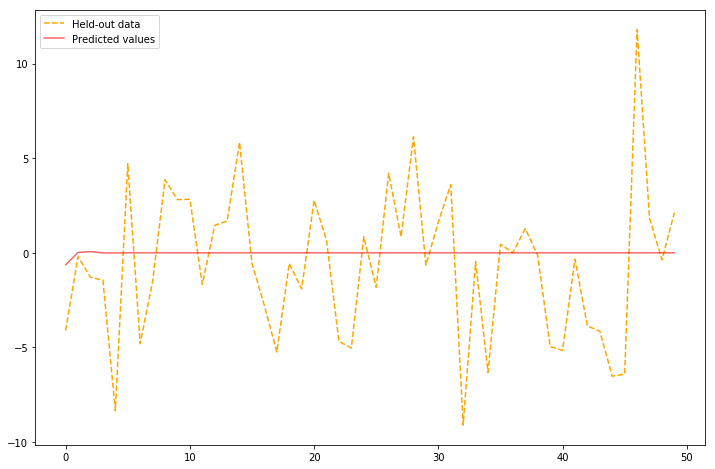

In [259]:
#Let's zoom in
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

#Lets ignore dates to simplify plotting
ax1.plot(range(0,50), test, label='Held-out data', linestyle='--', color='orange')

pred = model_results.get_prediction(451, 500)

ax1.plot(range(0,50), pred.predicted_mean, 'r', alpha=.6, label='Predicted values')

ax1.legend(loc='best');

We can see that the predictive mean value trends toward 0.0 very quickly.

In summation, it appears that on this particular dataset, ARIMA doesn't provide very much predictive insight into the data.

There is also a possibility the module is not functioning correctly.  Further testing should be done.